# Lab 3: RNNs and LSTMs
In this tutorial we create neural networks using [Recurrent Neural Networks (RNN)](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) and [Long Short-Term Memory (LSTM)](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) cells. The data and its pre-processing for of this notebook is identical to the first lab (Perceptron) to keep the amount of new information limited. Some of the required code-blocks are empty - requiring your imput to complete the model. A few additional questions at the end challenge you to play around with the code and try things for yourselves.

During the session, you will create a RNN to translate DNA sequences into protein sequences. 

In [51]:

# import pytorch
import torch
import torch.nn as nn
from torch import Tensor
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import lightning as L

# import basic functionality
import random
import numpy as np
import pandas as pd
import itertools

# libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt

import Bio
from Bio import SeqIO


# Step 1: Pre-processing the data
Here we download and pre-process the dataset. As before, we only consider DNA sequences that are protein coding, contain a integer number of codons, have a start and stop codon, and do not contain any uncertain nucleotides. Finally, we remove duplicates and randomly mix the sequences. Nothing is different from the last time, so you can simply execute these steps and move on to Step 2.

In [52]:

# download and unpack DNA coding sequences for human, mouse and yeast
############################

!mkdir -p all_seqs
!curl https://ftp.ensembl.org/pub/current_fasta/homo_sapiens/cds/Homo_sapiens.GRCh38.cds.all.fa.gz > all_seqs/Homo_sapiens.GRCh38.cds.all.fa.gz
!gzip -df "all_seqs/Homo_sapiens.GRCh38.cds.all.fa.gz"


/home/course
--2026-02-19 16:32:54--  https://ftp.ensembl.org/pub/current_fasta/homo_sapiens/cds/Homo_sapiens.GRCh38.cds.all.fa.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.169
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31915256 (30M) [application/x-gzip]
Saving to: ‘/home/course/all_seqs/Homo_sapiens.GRCh38.cds.all.fa.gz’

Homo_sapiens.GRCh38 100%[===================>]  30.44M  32.2MB/s    in 0.9s    

2026-02-19 16:32:55 (32.2 MB/s) - ‘/home/course/all_seqs/Homo_sapiens.GRCh38.cds.all.fa.gz’ saved [31915256/31915256]



In [53]:

# function that loads and processes a FASTA file containing coding sequences
def load_species_cds(file_name):
    dna_seq = []
    prot_seq = []
    for record in SeqIO.parse(file_name, "fasta"):
        # ensure that sequences are protein coding
        if 'gene_biotype:protein_coding' in record.description:
            if 'transcript_biotype:protein_coding' in record.description:
                if ' cds ' in record.description:
                    if len(record.seq) % 3 == 0:
                        dna_seq.append(str(record.seq))
                        prot_seq.append(str(record.seq.translate()))
                        
    # keep sequences that are protein coding
    dna_seq_cod = []
    prot_seq_cod = []
    for i in range(len(prot_seq)):
        if (prot_seq[i][0]=='M') & (prot_seq[i][-1]=='*'):  #  A valid coding sequence should: Start with M (Methionine — the start codon AUG), End with * (stop codon)
            dna_seq_cod.append(dna_seq[i])
            prot_seq_cod.append(prot_seq[i])

    # avoid sequences with undetermined/uncertain nucleotides
    dna_seq_cod = [dna_seq_cod[i] for i in range(len(dna_seq_cod)) if ('N' not in dna_seq_cod[i])]    # N in DNA means the nucleotide is unknown/undetermined. 
    prot_seq_cod = [prot_seq_cod[i] for i in range(len(dna_seq_cod)) if ('N' not in dna_seq_cod[i])]
 
    # remove duplicates and randomly mix the list of sequences
    seqs = list(zip(dna_seq_cod, prot_seq_cod))
    seqs = list(set(seqs))
    random.shuffle(seqs)
    dna_seq_cod, prot_seq_cod = zip(*seqs)

    # pack samples as a list of dictionaries and return result
    seq_data = [{'dna':dna_seq_cod[i],'prot':prot_seq_cod[i]} for i in range(len(dna_seq_cod))]
    return seq_data
    

In [54]:

# load coding sequences for different species
print('loading human proteins')
seq_data = load_species_cds("all_seqs/Homo_sapiens.GRCh38.cds.all.fa")

# take a look at some sequences
[seq_data[i]['dna'][0:20]+'...'+seq_data[i]['dna'][-20:] for i in range(5)]

loading human proteins


['ATGGACCAAAGACAGAGGAG...ACGCAAATAAAATTCTGTAA',
 'ATGGAGGAGGAAGAGGAGGC...ACTTCTCCACCGACGTGTAG',
 'ATGGGGTCGCAGCCGCCGCT...GAGACTGTGATATGTCTTAA',
 'ATGGGGCTGCAGCCCCTGGA...ACTACGTCAAGCTGCTGTAG',
 'ATGATGAAGAGGCAGCTGCA...TTGCCTCAGAGACCAACTGA']

In [55]:
print('number of sequences: ', len(seq_data))

number of sequences:  117302


# Step 2: Encoding the sequences
Having prepared the coding sequences and their translation, we convert them into a numeric representation as vectors. To do so, we first construct a language class that stores words of each language and allows us to convert between encoding/indices and words in a language. We define a function that allows us to store any sequence of words (i.e., codons or bases) as a numeric representation. Here we extend every sequence with a start of sentence <SOS> and end of sentence <EOS> token, such that the model knows when to start and stop translating. Finally, we can extend every sentence to the same length by padding with an empty "word" that is not translated or used, but allows us to use the identical-length numerical representation of the sentences as input for the model. The language allows for a simple encoding of words as numbers or as numerical vectors (one-hot-encoding). The 'encode' function converts an input sentence to the specified encoding.

In [56]:
class Language:
    """
    Represents a biological sequence vocabulary (e.g., codons or nucleotide bases).
    Handles building a vocabulary from sequences and encoding them into numeric
    representations suitable for use in a neural network.
    """

    def __init__(self, name, codon_len):
        """
        Args:
            name      : name of the language (e.g., "DNA", "protein")
            codon_len : number of characters per word/token (e.g., 3 for codons, 1 for bases)
        """
        self.name = name
        self.codon_length = codon_len

        # Bidirectional lookup between words and their numeric indices.
        # Pre-populated with <PAD> at index 0, used to equalize sequence lengths.
        self.word2index = {"<PAD>": 0}
        self.index2word = {0: "<PAD>"}

        # Tracks total vocabulary size; starts at 1 since index 0 is reserved for <PAD>
        self.n_words = 1

        # Stores the active encoding scheme (integer or one-hot), set by as_encoding() or as_one_hot()
        self.encoding = {}

    def addSentence(self, sentence):
        """
        Splits a raw sequence string into words of length codon_len and adds
        any new words to the vocabulary.

        Example: "ATGCGA" with codon_len=3 → ["ATG", "CGA"]
        """
        words = [sentence[i:i+self.codon_length] for i in range(0, len(sentence), self.codon_length)]
        for word in words:
            self.addWord(word)

    def addWord(self, word):
        """
        Adds a single word to the vocabulary if it hasn't been seen before.
        Assigns it the next available index and creates both lookup directions.
        """
        if word not in self.word2index:
            self.word2index[word] = self.n_words      # word  → index
            self.index2word[self.n_words] = word      # index → word
            self.n_words += 1                         # increment vocabulary size

    def as_one_hot(self):
        """
        Sets the encoding scheme to one-hot vectors.
        Each word becomes a binary vector of length = vocabulary size,
        with a 1 at its own index and 0s everywhere else.

        Example with vocab size 4: index 2 → [0, 0, 1, 0]
        """
        for word in self.word2index:
            one_hot = np.zeros(len(self.word2index), dtype=np.int32)  # create zero vector
            one_hot[self.word2index[word]] = 1                        # place 1 at word's index
            self.encoding[word] = one_hot

    def as_encoding(self):
        """
        Sets the encoding scheme to simple integer indices.
        Each word maps directly to its integer index (e.g., "ATG" → 3).
        More memory-efficient than one-hot but less expressive as model input.
        """
        self.encoding = self.word2index

    def encode(self, sentence, max_len):
        """
        Converts a raw sequence string into a padded or truncated PyTorch tensor
        using the active encoding scheme.

        Args:
            sentence : raw sequence string (e.g., "ATGCGATTT")
            max_len  : desired output length in words; pads if shorter, truncates if longer.
                       If None, returns the sequence at its natural length.

        Returns:
            torch.Tensor of shape (max_len,) or (sequence_length,) if max_len is None
        """
        # Get the encoded representation of the padding token for filling short sequences
        pad = [self.encoding["<PAD>"]]

        # Split the raw string into a list of words of length codon_len
        sentence_split = [sentence[i:i+self.codon_length] for i in range(0, len(sentence), self.codon_length)]

        # Replace each word with its numeric encoding (integer index or one-hot vector)
        sentence_encoded = [self.encoding[word] for word in sentence_split]

        if max_len is not None:
            if len(sentence_split) < max_len:
                # Sequence is too short — append padding tokens to reach max_len
                n_pads = max_len - len(sentence_split)
                return torch.Tensor(np.array(sentence_encoded + pad * n_pads))
            else:
                # Sequence is too long — cut off everything beyond max_len
                return torch.Tensor(np.array(sentence_encoded[:max_len]))
        else:
            # No length constraint — return the full encoded sequence as-is
            return torch.Tensor(np.array(sentence_encoded))

In [57]:
########################
### Step 2a: Build vocabularies for DNA and protein sequences
########################

# --- Define the two languages ---
# DNA is read in triplets (codons), so codon_len=3 (e.g., "ATGCGA" → ["ATG", "CGA"])
# Protein is read one amino acid at a time, so codon_len=1 (e.g., "MR" → ["M", "R"])
dna_lang  = Language(name="dna",  codon_len=3)
prot_lang = Language(name="prot", codon_len=1)

# --- Split the dataset into training, validation, and test sets ---
# seq_data contains all available DNA/protein sequence pairs (defined above)
# Typical splits: ~80% train, ~10% validation, ~10% test
# More training data helps the model generalise; validation monitors overfitting during training;
# test set gives a final unbiased performance estimate after training is complete
train_set, val_set, test_set = torch.utils.data.random_split(seq_data, [0.8, 0.1, 0.1])

# --- Build vocabularies from the training set only ---
# We only parse training sequences to avoid any information from validation/test
# leaking into the vocabulary (data leakage). This simulates a realistic scenario
# where unseen sequences may appear at inference time.
for cur_seq in train_set:
    dna_lang.addSentence(cur_seq['dna'])    # adds all unique codons (triplets) to the DNA vocabulary
    prot_lang.addSentence(cur_seq['prot'])  # adds all unique amino acids to the protein vocabulary

# --- Set the encoding scheme for each language ---
# DNA uses one-hot encoding: each codon becomes a sparse binary vector.
# This is preferred for the input since it treats all codons as equally distant,
# avoiding the model misinterpreting integer indices as having ordinal meaning (e.g., 3 > 2 > 1).
dna_lang.as_one_hot()

# Protein uses simple integer encoding: each amino acid maps to a single index.
# This is suitable for the output/target, since the loss function (cross-entropy)
# expects class indices rather than one-hot vectors.
prot_lang.as_encoding()

In [58]:

# here we define a function for encoding a dataset of dna and protein sequences
def encode_dataset(dataset, dna_lang, prot_lang, max_length):
    dataset_encoded = [
        { 
          'dna'  : dna_lang.encode(dataset[i]['dna'], max_len=max_length),
          'prot' : prot_lang.encode(dataset[i]['prot'], max_len=max_length)
        } for i in range(len(dataset))
    ]
    return dataset_encoded
    

Min    : 9
Max    : 35992
Mean   : 586.6
Median : 471.0
95th % : 1385.9


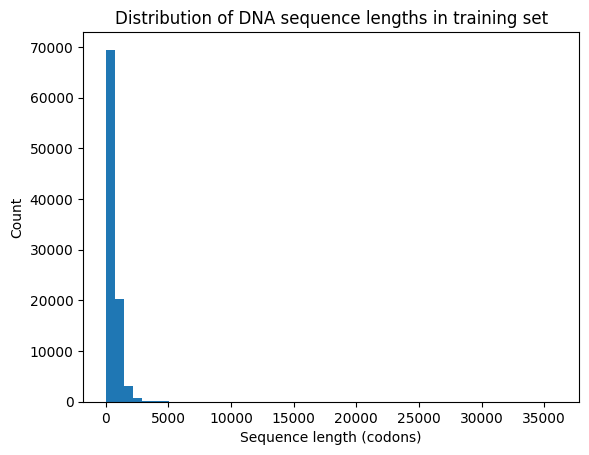

In [9]:
# Check the distribution of DNA sequence lengths (in codons) across the training set
dna_lengths = [len(cur_seq['dna']) // 3 for cur_seq in train_set]

print(f"Min    : {np.min(dna_lengths)}")
print(f"Max    : {np.max(dna_lengths)}")
print(f"Mean   : {np.mean(dna_lengths):.1f}")
print(f"Median : {np.median(dna_lengths):.1f}")
print(f"95th % : {np.percentile(dna_lengths, 95):.1f}")

plt.hist(dna_lengths, bins=50)
plt.xlabel("Sequence length (codons)")
plt.ylabel("Count")
plt.title("Distribution of DNA sequence lengths in training set")
plt.show()

In [10]:
########################
### step2b: encode your sequences here
########################

# define maximum number of codons
# we truncate any sequence longer than this length, and pad any sequence shorter than this length
# think about a sensible length for the input sequences
max_length = int(np.percentile(dna_lengths, 70))

# encode the training and validation data
train_set_encoded = encode_dataset(train_set, dna_lang, prot_lang, max_length) 
val_set_encoded = encode_dataset(val_set, dna_lang, prot_lang, max_length)


In [11]:

# take a look at the encoding of a DNA
train_set[0]['dna'], train_set_encoded[0]['dna'].shape


('ATGGGCTGTGTGCAATGTAAGGATAAAGAAGCAACAAAACTGACGGAGGAGAGGGACGGCAGCCTGAACCAGAGCTCTGGGTACCGCTATGGCACAGACCCCACCCCTCAGCACTACCCCAGCTTCGGTGTGACCTCCATCCCCAACTACAACAACTTCCACGCAGCCGGGGGCCAAGGACTCACCGTCTTTGGAGGTGTGAACTCTTCGTCTCATACGGGGACCTTGCGTACGAGAGGAGGAACAGGAGTGACACTCTTTGTGGCCCTTTATGACTATGAAGCACGGACAGAAGATGACCTGAGTTTTCACAAAGGAGAAAAATTTCAAATATTGAACAGCTCGTGGTACTTTGGAAAACTTGGCCGAAAAGATGCTGAGCGACAGCTATTGTCCTTTGGAAACCCAAGAGGTACCTTTCTTATCCGCGAGAGTGAAACCACCAAAGGTGCCTATTCACTTTCTATCCGTGATTGGGATGATATGAAAGGAGACCATGTCAAACATTATAAAATTCGCAAACTTGACAATGGTGGATACTACATTACCACCCGGGCCCAGTTTGAAACACTTCAGCAGCTTGTACAACATTACTCAGAGAAAGCTGATGGTTTGTGTTTTAACTTAACTGTGATTGCATCGAGTTGTACCCCACAAACTTCTGGATTGGCTAAAGATGCTTGGGAAGTTGCACGTCGTTCGTTGTGTCTGGAGAAGAAGCTGGGTCAGGGGTGTTTCGCTGAAGTGTGGCTTGGTACCTGGAATGGAAACACAAAAGTAGCCATAAAGACTCTTAAACCAGGCACAATGTCCCCCGAATCATTCCTTGAGGAAGCGCAGATCATGAAGAAGCTGAAGCACGACAAGCTGGTCCAGCTCTATGCAGTGGTGTCTGAGGAGCCCATCTACATCGTCACCGAGTATATGAACAAAGGAAGTTTACTGGATTTCTTAAAAGATGGAGAAGGAAGAGCTCTGAAATTACCAAATCTTGTGGA

In [12]:

# take a look at the encoding of a protein
train_set[0]['prot'], train_set_encoded[0]['prot'].shape


('MGCVQCKDKEATKLTEERDGSLNQSSGYRYGTDPTPQHYPSFGVTSIPNYNNFHAAGGQGLTVFGGVNSSSHTGTLRTRGGTGVTLFVALYDYEARTEDDLSFHKGEKFQILNSSWYFGKLGRKDAERQLLSFGNPRGTFLIRESETTKGAYSLSIRDWDDMKGDHVKHYKIRKLDNGGYYITTRAQFETLQQLVQHYSEKADGLCFNLTVIASSCTPQTSGLAKDAWEVARRSLCLEKKLGQGCFAEVWLGTWNGNTKVAIKTLKPGTMSPESFLEEAQIMKKLKHDKLVQLYAVVSEEPIYIVTEYMNKGSLLDFLKDGEGRALKLPNLVDMAAQVAAGMAYIERMNYIHRDLRSANILVGNGLICKIADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELVTKGRVPYPGMNNREVLEQVERGYRMPCPQDCPISLHELMIHCWKKDPEERPTFEYLQSFLEDYFTATEPQYQPGENL*',
 torch.Size([673]))

In [13]:

# define dataloader for the encoded sequences
def get_dataloader(dataset, batch_size):
    cur_sampler = RandomSampler(dataset)
    cur_dataloader = DataLoader(dataset, sampler=cur_sampler, batch_size=batch_size, drop_last=True, num_workers=16)
    return cur_dataloader
    

In [15]:
# Check how many encoded samples you have and the size of each tensor
print(f"Training samples : {len(train_set_encoded)}")
print(f"Validation samples : {len(val_set_encoded)}")
print(f"DNA tensor shape : {train_set_encoded[0]['dna'].shape}")
print(f"Protein tensor shape : {train_set_encoded[0]['prot'].shape}")

Training samples : 93842
Validation samples : 11730
DNA tensor shape : torch.Size([673, 65])
Protein tensor shape : torch.Size([673])


In [22]:
########################
### step 2c: create a dataloader for the validation and training sequences
########################

# how many samples should be trained on simultaneously?
batch_size = 16

# define dataloader for training
train_loader = torch.utils.data.DataLoader(train_set_encoded, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = torch.utils.data.DataLoader(val_set_encoded,   batch_size=batch_size, shuffle=False, drop_last=True)

sample_batch = next(iter(train_loader))
print(f"DNA batch shape     : {sample_batch['dna'].shape}")   # expected: (batch_size, max_length, vocab_size)
print(f"Protein batch shape : {sample_batch['prot'].shape}")  # expected: (batch_size, max_length)

DNA batch shape     : torch.Size([16, 673, 65])
Protein batch shape : torch.Size([16, 673])


## Dataset & DataLoader Summary

| | Count |
|---|---|
| Training samples | 93,842 |
| Validation samples | 11,730 |
| Split | ~80/10 ✓ |

### Tensor shapes (per sequence)
| Tensor | Shape | Explanation |
|---|---|---|
| DNA | `[673, 65]` | 673 codons × 65 one-hot vector (64 codons + `<PAD>`) |
| Protein | `[673]` | 673 integers, one per amino acid position |

### Batch shapes (batch_size=16)
| Tensor | Shape |
|---|---|
| DNA | `(16, 673, 65)` |
| Protein | `(16, 673)` |


# Step 3: Define model
We created languages for DNA and protein sequences, and encoded all sequences through the encodings defined by these languages. We then created data loaders for these encoded sequences. As a final preparation, we define our [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html).
Create a class that instructs pytorch to make a RNN model using the given input, hidden size and output parameters. You'll have to define the init and forward functions. Additionally, in the Pytorch Lightning class, you must choose a loss function and optimizer that are appropriate for the problem you are trying to solve. Once you have thought about your model, we will go over the architecture together with the class. Hint: for the RNN, you'll need to also define the hidden state.

In [23]:

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [30]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        
        # RNN layer: takes input of shape (seq_len, batch, input_size)
        # outputs: output of shape (seq_len, batch, hidden_size), hidden state
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        
        # Fully connected layer to map hidden state -> output classes
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_data):
        # input_data: [batch, seq_len, features]  ← batch-first!
        batch_size = input_data.size(0)           # ← now dim 0, not dim 1
        device = input_data.device
    
        h0 = torch.zeros(1, batch_size, self.rnn.hidden_size).to(device)
    
        # out shape: [batch, seq_len, hidden_size]  (with batch_first=True)
        out, hn = self.rnn(input_data, h0)
    
        # Apply fc to EVERY timestep, not just the last hidden state
        # out: [batch, seq_len, hidden_size] → [batch, seq_len, output_size]
        out = self.fc(out)
    
        # CrossEntropyLoss expects [batch, num_classes, seq_len]
        out = out.permute(0, 2, 1)   # → [batch, output_size, seq_len]
    
        return out

In [35]:
########################
### step 3b: define the lightning module to train the model
########################

# lightning module to train the sequence model
class SequenceModelLightning(L.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, lr=0.1):
        super().__init__()
        self.model = MyRNN(input_size, hidden_size, output_size)
        self.lr = lr

        ########################
        # define loss function here, pseudocode:
        self.loss = nn.CrossEntropyLoss()
        ########################

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        input_tensor = batch['dna']
        target_tensor = batch['prot'].long()
        
        output = self.model(input_tensor)
        loss = self.loss(input=output, target=target_tensor)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_tensor = batch['dna']
        target_tensor = batch['prot'].long()

        output = self.model(input_tensor)
        loss = self.loss(input=output, target=target_tensor)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        # define optimizer here
        return optim.Adam(self.model.parameters(), lr=self.lr)
    

In [36]:
batch = next(iter(train_loader))
print(batch['dna'].shape)   # → [seq_len, batch, 65]
print(batch['prot'].shape)  # → check output_size too

torch.Size([16, 673, 65])
torch.Size([16, 673])


In [37]:
# assuming your dataset/dataloaders are already defined as train_loader, val_loader
lit_model = SequenceModelLightning(
    input_size  = dna_lang.n_words,   # replaces hardcoded 65
    hidden_size = 128,
    output_size = prot_lang.n_words,  # replaces hardcoded 20
    lr          = 1e-3
)
trainer = L.Trainer(
    devices    = 1,
    max_epochs = 20       # start small, watch val_loss
)
trainer.fit(lit_model, train_loader, val_loader)
#                      ^^^^^^^^^^^^  ^^^^^^^^^^
#                      train data    validation data

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------
0 | model | MyRNN            | 27.8 K | train | 0    
1 | loss  | CrossEntropyLoss | 0      | train | 0    
-----------------------------------------------------------
27.8 K    Trainable params
0         Non-trainable params
27.8 K    Total params
0.111     Total estimated model params size (MB)
4         Modules in train mod

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

/home/course/bc_deep_learning_in_biology/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


# Step 4: Test the model on random test sequences

In [38]:

# show the model architecture
my_rnn = lit_model.model
my_rnn


MyRNN(
  (rnn): RNN(65, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=22, bias=True)
)

In [39]:

# we encode the test data using the same dna and protein language encodings we defined before
# if you change the languages, you need to re-encode the test sequences as well!
test_set_encoded = encode_dataset(test_set, dna_lang, prot_lang, max_length)


In [44]:
########################
### step4: define the input tensor and get the prediction from your model
########################

# pick a random sequence from the test set
random_pair = np.random.randint(0,len(test_set))

# get the encoded dna sequence and its known protein translation
dna_sequence = np.array([test_set_encoded[random_pair]['dna']])
protein_translation = test_set[random_pair]['prot']
target_tensor = test_set_encoded[random_pair]['prot']

# send model and input sequence to device, compute translation of sequence
my_rnn.to(device)
########################
input_tensor = torch.Tensor(dna_sequence).to(device)   # shape: [1, max_length, 65]
output = my_rnn(input_tensor).squeeze(0).T         # [max_length, 22]
########################

loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(output, target_tensor.long().to(device))
print('loss:', loss.item())

# convert output back to protein sequence by taking the most likely amino acid per position, print results
result = "".join([prot_lang.index2word[i] for i in output.cpu().topk(1)[1].view(-1).numpy()])
print(''+protein_translation)
print(result, end='\n\n')

# print accuracy
result = "".join([prot_lang.index2word[i] for i in output.cpu().topk(1)[1].view(-1).numpy() if i not in [key for key in Language('',1).index2word]])
min_len = np.min([len(result),len(protein_translation)])
print('Accuracy of aa calling over the sequence: ', np.sum([protein_translation[i] == result[i] for i in range(min_len)])/min_len)


loss: 5.046466640123981e-07
MGPGRCLLTALLLLALAPPPEASQYCGRLEYWNPDNKCCSSCLQRFGPPPCPELSSLASQPLSRLLDELEVLEELIVLLDPEPGPGGGMAHGTTRHLAARYGLPAAWSTFAYSLRPSRSPLRALIEMVVAREPSASLGQLGTHLAQLGRADALRVLSKLGSSGVCWA*
MGPGRCLLTALLLLALAPPPEASQYCGRLEYWNPDNKCCSSCLQRFGPPPCPELSSLASQPLSRLLDELEVLEELIVLLDPEPGPGGGMAHGTTRHLAARYGLPAAWSTFAYSLRPSRSPLRALIEMVVAREPSASLGQLGTHLAQLGRADALRVLSKLGSSGVCWA*<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

# Step 5: Interpret the RNN hidden state
The RNN you trained has a hidden state, a matrix of size (# of codons) x (# of amino acids). Load the hidden state and interpret the parameter values.

## Interpreting the RNN weights

The RNN applies two sequential linear transformations:

$$\text{input (65)} \xrightarrow{W_{ih}} \text{hidden (128)} \xrightarrow{W_{fc}} \text{output (22)}$$

Because both are linear, we can collapse them into a single transformation:

$$W_{combined} = (W_{fc} \cdot W_{ih})^T \quad \text{shape: } [65 \times 22]$$

This gives a direct **codon → amino acid** score matrix, where each row is a codon and each column is an amino acid — making the learned genetic code directly readable.

In [45]:
# extract weight matrices from the trained RNN
W_ih = my_rnn.rnn.weight_ih_l0.detach().cpu().numpy()  # [128, 65] input→hidden
W_fc = my_rnn.fc.weight.detach().cpu().numpy()          # [22, 128] hidden→output

# multiply to get direct codon→amino acid relationship [65, 22]
W_combined = (W_fc @ W_ih).T   # [65, 22]

# annotate rows with codon names, columns with amino acid names
codon_names = [dna_lang.index2word[i] for i in range(dna_lang.n_words)]
aa_names    = [prot_lang.index2word[i] for i in range(prot_lang.n_words)]

rnn_param = pd.DataFrame(W_combined, index=codon_names, columns=aa_names)

rnn_param

,<PAD>,M,G,C,V,Q,K,D,E,A,...,R,S,N,Y,P,H,F,I,W,*
<PAD>,-1433.659912,-1612.859497,-1639.830811,-1624.540161,-1616.310913,-1627.346313,-1614.610718,-1628.405396,-1633.798340,-1617.509399,...,-1621.950073,-1624.817383,-1626.861938,-1625.237427,-1626.596680,-1628.604370,-1628.649902,-1628.597534,-1625.541626,-1615.566650
ATG,-218.839523,-122.018730,-254.144257,-242.131958,-238.615814,-255.189163,-250.104599,-259.996368,-262.396484,-263.309326,...,-262.299622,-251.904526,-256.399536,-255.457077,-257.114746,-250.937698,-285.389618,-276.465546,-250.188690,-259.297638
GGC,-502.356140,-519.449097,-402.076263,-538.330872,-531.479492,-523.565247,-523.649658,-532.511108,-535.974182,-538.693115,...,-537.125122,-533.804993,-533.933899,-528.067078,-533.251282,-537.050110,-531.776794,-537.381470,-528.925415,-528.370422
TGT,65.796028,65.478096,42.088753,184.357376,53.450008,59.291008,50.349422,54.864731,44.917328,52.898315,...,52.704090,50.266495,48.029644,43.054886,50.989944,58.415493,47.648403,51.400364,58.561649,50.492386
GTG,-469.839752,-472.833130,-483.976013,-477.972992,-335.527191,-473.795441,-485.714935,-477.719727,-478.981171,-479.243927,...,-485.663727,-494.873901,-499.256622,-478.414764,-484.044006,-483.285858,-480.345306,-493.789154,-488.323547,-480.280426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGC,-17.156052,-17.065401,-41.843193,103.568451,-29.373875,-24.581038,-31.592749,-27.051168,-37.834671,-30.660053,...,-30.155308,-31.304474,-34.382687,-40.645161,-32.958843,-25.041622,-36.312691,-30.520380,-25.132248,-31.491121
CCG,182.315994,206.573425,206.802811,212.276031,201.462173,205.005173,214.115005,213.678696,207.209686,197.113388,...,202.641678,208.984177,210.042786,208.745300,319.527557,202.367691,208.140457,201.022476,213.454025,203.322342
TAA,38.044037,17.503319,25.803753,20.471748,36.207939,30.474297,36.767334,16.335384,3.938364,40.964729,...,18.671495,3.199365,42.382500,27.032177,24.026821,42.384945,37.460182,33.410889,23.786301,132.905838
TGA,65.491013,48.434017,58.717350,53.627419,67.341713,67.339752,70.736794,50.878750,39.467037,72.723732,...,48.510513,36.378990,74.087624,54.632236,56.836147,75.318848,73.492775,64.822281,59.203266,162.350616


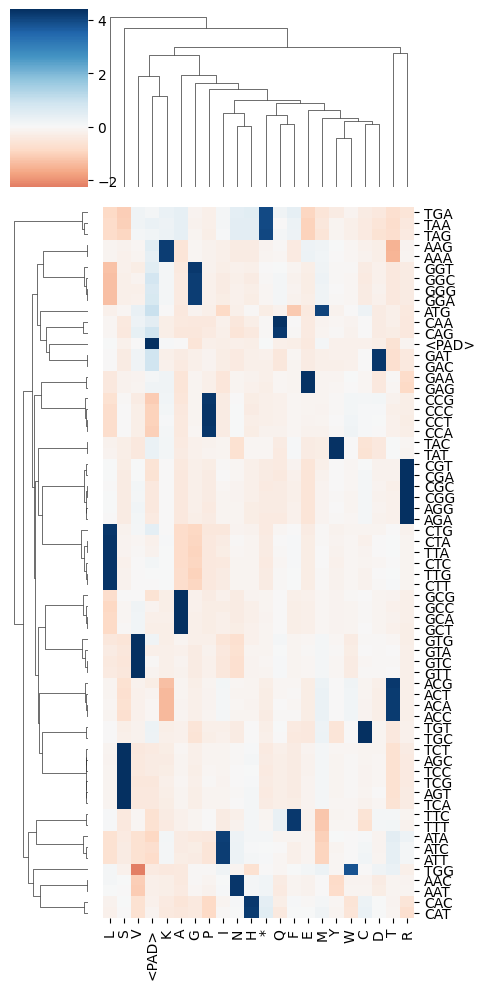

In [47]:

import seaborn as sns
import matplotlib.pyplot as plt

# plot the hidden state of the RNN. What is the interpretation?
use_map =  sns.color_palette("RdBu",as_cmap=True)
clus = sns.clustermap(
                        rnn_param,
                        z_score=0,
                        center=0,
                        xticklabels=True, yticklabels=True, 
                        row_cluster=True, col_cluster=True, 
                        cmap=use_map,
                        figsize=(5,10),
                        method='complete', metric='cityblock'
                     )

plt.rcParams['pdf.fonttype'] = 42 
plt.tight_layout()
plt.show()


# Steps:
2a: create languages for the DNA and protein sequences <br>
2b: encode the training and validation sequences <br>
2c: create a dataloader for the validation and training sequences <br>
3a: define your RNN model <br>
3b: define the lightning module to train the model <br>
3c: define the input parameters for the training loop <br>
Train your model :) <br>
4: define the input tensor and get the prediction from your model <br>
5: interpret the hidden state of your RNN

# Questions

## 1. Training on arbitrary length sequences
The current model is trained on **truncated and padded** sequences of fixed length.
Modify the setup to train on sequences at their **actual length** instead.

> Before training, consider:
> - How many samples should you use for training?
> - What batch size is appropriate?
> - How many epochs do you need?

## 2. Nucleotides instead of codons
Change the codon length to train the model on **individual nucleotides** rather than codons.

> ⚠️ This is tricky — think carefully about the dimensionality of your input and output data!

Does your RNN still train well at the nucleotide level?

## 3. LSTM vs RNN
Add a second model that uses an **LSTM** instead of a plain RNN.

> Does the LSTM train better than the RNN? Why or why not?

In [62]:
from torch.nn.utils.rnn import pad_sequence

# custom collate function to pad sequences to longest in each batch
def collate_fn(batch):
    dna_seqs  = [dna_lang.encode(b['dna'],  max_len=None) for b in batch]
    prot_seqs = [prot_lang.encode(b['prot'], max_len=None) for b in batch]
    
    dna_padded  = pad_sequence(dna_seqs,  batch_first=True)  # [batch, max_len_in_batch, 65]
    prot_padded = pad_sequence(prot_seqs, batch_first=True)  # [batch, max_len_in_batch]
    
    return {'dna': dna_padded, 'prot': prot_padded}

# dataloaders using raw (non-encoded) datasets with collate_fn
train_loader_arb = DataLoader(train_set, batch_size=8,  shuffle=True,  drop_last=True, collate_fn=collate_fn)
val_loader_arb   = DataLoader(val_set,   batch_size=8,  shuffle=False, drop_last=True, collate_fn=collate_fn)

# train — smaller batch size since sequences vary in length and memory usage varies
lit_model_arb = SequenceModelLightning(
    input_size  = dna_lang.n_words,
    hidden_size = 128,
    output_size = prot_lang.n_words,
    lr          = 1e-3
)
trainer_arb = L.Trainer(devices=1, max_epochs=20)
trainer_arb.fit(lit_model_arb, train_loader_arb, val_loader_arb)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------
0 | model | MyRNN            | 27.8 K | train | 0    
1 | loss  | CrossEntropyLoss | 0      | train | 0    
-----------------------------------------------------------
27.8 K    Trainable params
0         Non-trainable params
27.8 K    Total params
0.111     Total estimated model params size (MB)
4         Modules in train mod

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## 1. Training on Arbitrary Length Sequences

To train on sequences at their actual length, a custom `collate_fn` was used with `pad_sequence`,
which pads dynamically to the longest sequence **within each batch** rather than a global maximum.
This is more memory-efficient and avoids unnecessary padding across the whole dataset.

**Training choices:**
- **Batch size: 8** — reduced from the fixed-length setup because variable-length sequences cause
  fluctuating memory usage per batch; a smaller batch size avoids out-of-memory errors
- **Samples:** full training set used
- **Epochs: 20** — sufficient for convergence

**Results:** The model converged well, reaching a train loss of ~2.6e-8 and val loss of ~1.16e-7,
closely matching the original fixed-length model (val loss ~1.17e-7). This confirms that dynamic
padding does not hurt performance while being more biologically faithful to real sequence lengths.

In [63]:
# redefine languages with codon_len=1 for nucleotides
dna_lang_nt  = Language(name="dna_nt",  codon_len=1)
prot_lang_nt = Language(name="prot_nt", codon_len=1)

for cur_seq in train_set:
    dna_lang_nt.addSentence(cur_seq['dna'])
    prot_lang_nt.addSentence(cur_seq['prot'])

dna_lang_nt.as_one_hot()
prot_lang_nt.as_encoding()

# encode dataset: DNA at nucleotide level, protein repeated 3x to match length
def encode_dataset_nt(dataset, dna_lang, prot_lang, max_length):
    dataset_encoded = []
    for i in range(len(dataset)):
        dna_enc  = dna_lang.encode(dataset[i]['dna'],  max_len=max_length * 3)
        prot_enc = prot_lang.encode(dataset[i]['prot'], max_len=max_length)
        prot_repeated = prot_enc.repeat_interleave(3)  # each AA repeated 3x for 3 nucleotides
        dataset_encoded.append({'dna': dna_enc, 'prot': prot_repeated})
    return dataset_encoded

max_length_nt = int(np.percentile(dna_lengths, 70))  # same as before but in codons

train_set_encoded_nt = encode_dataset_nt(train_set, dna_lang_nt, prot_lang_nt, max_length_nt)
val_set_encoded_nt   = encode_dataset_nt(val_set,   dna_lang_nt, prot_lang_nt, max_length_nt)

train_loader_nt = DataLoader(train_set_encoded_nt, batch_size=16, shuffle=True,  drop_last=True)
val_loader_nt   = DataLoader(val_set_encoded_nt,   batch_size=16, shuffle=False, drop_last=True)

# same RNN model, just different input/output sizes
lit_model_nt = SequenceModelLightning(
    input_size  = dna_lang_nt.n_words,   # 5: A, T, G, C + <PAD>
    hidden_size = 128,
    output_size = prot_lang_nt.n_words,  # same 22 as before
    lr          = 1e-3
)
trainer_nt = L.Trainer(devices=1, max_epochs=20)
trainer_nt.fit(lit_model_nt, train_loader_nt, val_loader_nt)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------
0 | model | MyRNN            | 20.1 K | train | 0    
1 | loss  | CrossEntropyLoss | 0      | train | 0    
-----------------------------------------------------------
20.1 K    Trainable params
0         Non-trainable params
20.1 K    Total params
0.080     Total estimated model params size (MB)
4         Modules in train mod

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## 2. Nucleotides Instead of Codons

Switching from codons to nucleotides introduces a dimensionality mismatch that must be handled carefully:

| Level | DNA Sequence Length | Protein Sequence Length |
| :--- | :--- | :--- |
| **Codon** | $L$ | $L$ |
| **Nucleotide** | $3 \times L$ | $L$ |

Because the RNN produces one output per input timestep, the target sequence must match the input length. 

**The Fix:** We use `repeat_interleave(3)` on the protein labels. This ensures each of the three nucleotides in a codon is assigned the label of the amino acid it encodes. 

**Model Complexity:** The input vocabulary shrinks significantly. Instead of 65 possible codons, the model sees only 5 tokens (A, T, G, C, PAD). This reduces the model size from **27.8K** to **20.1K** parameters by shrinking the input embedding space.

---

### Does the RNN train well at the nucleotide level?

**No — the nucleotide-level RNN performs poorly.** Final losses (~0.48 train, ~0.45 val) are orders of magnitude higher than the codon-level model (~$1\times10^{-7}$). The reason is fundamental:

1.  **Implicit Learning:** A plain RNN must implicitly learn that every group of exactly 3 consecutive nucleotides encodes one amino acid. 
2.  **Temporal Buffering:** The hidden state must "count" and buffer nucleotides across 3 steps before it has enough information to make a meaningful prediction. 
3.  **Inductive Bias:** The codon representation provides this biological structure **explicitly**, whereas the nucleotide model forces the RNN to learn the concept of a "reading frame" from scratch—a task these architectures struggle with without specific attention mechanisms or convolutional filters.

In [64]:
# define LSTM model — identical to MyRNN except nn.LSTM and tuple hidden state
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, output_size)

    def forward(self, input_data):
        batch_size = input_data.size(0)
        device     = input_data.device

        h0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(device)
        c0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(device)  # extra cell state

        out, (hn, cn) = self.lstm(input_data, (h0, c0))  # LSTM returns (output, (h, c))
        out = self.fc(out)
        out = out.permute(0, 2, 1)
        return out


# updated lightning module supporting both RNN and LSTM
class SequenceModelLightningV2(L.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, lr=1e-3, model_type='lstm'):
        super().__init__()
        self.model = MyLSTM(input_size, hidden_size, output_size) if model_type == 'lstm' \
                else MyRNN(input_size, hidden_size, output_size)
        self.loss = nn.CrossEntropyLoss()
        self.lr   = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        output = self.model(batch['dna'])
        loss   = self.loss(output, batch['prot'].long())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        output = self.model(batch['dna'])
        loss   = self.loss(output, batch['prot'].long())
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.lr)


# train LSTM on the same data as the original RNN
lit_model_lstm = SequenceModelLightningV2(
    input_size  = dna_lang.n_words,
    hidden_size = 128,
    output_size = prot_lang.n_words,
    lr          = 1e-3,
    model_type  = 'lstm'
)
trainer_lstm = L.Trainer(devices=1, max_epochs=20)
trainer_lstm.fit(lit_model_lstm, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------
0 | model | MyLSTM           | 102 K  | train | 0    
1 | loss  | CrossEntropyLoss | 0      | train | 0    
-----------------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.411     Total estimated model params size (MB)
4         Modules in train mod

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## 3. LSTM vs Plain RNN

| Model | Parameters | Train Loss | Val Loss  |
|-------|----------:|----------:|----------:|
| RNN   | 27.8 K    | ~1.46e-7  | ~1.17e-7  |
| LSTM  | 102 K     | ~4.51e-8  | ~5.40e-8  |

The LSTM achieves roughly **2× lower validation loss** than the plain RNN, demonstrating better
learning of the DNA-to-protein translation task.

**Why does the LSTM train better?**

The LSTM adds a dedicated **cell state** and three learned gates (input, forget, output) on top of
the plain RNN's single recurrent connection. This allows it to:
- **Selectively retain** important information over many timesteps (forget gate)
- **Regulate** how much new input is incorporated (input gate)
- **Control** what is passed to the output at each step (output gate)

Plain RNNs suffer from **vanishing gradients** over long sequences, meaning that error signals
from early timesteps decay before they can influence the weights. In DNA-to-protein translation,
where context from earlier in the sequence matters, this is a significant limitation. The LSTM's
gating mechanism mitigates this, allowing it to propagate relevant information across longer
sequences — at the cost of ~4× more parameters.